In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
library("phyloseq")
library(ggplot2)
library("vegan")
library("dplyr")
library("plotly")

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: This is vegan 2.4-1

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [5]:
%%R
ps.FQS = subset_samples(physeq, (sample_data(physeq)$Trtmt=="Ferrihydrite"|sample_data(physeq)$Trtmt=="Quartz"|sample_data(physeq)$Trtmt=="Soil"))

In [6]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1500)

In [7]:
%%R
ps <- physeq.noSmall

In [8]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [9]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3, trymax=40)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1359395 
Run 1 stress 0.1371882 
Run 2 stress 0.1361693 
... Procrustes: rmse 0.03779633  max resid 0.1891506 
Run 3 stress 0.1386466 
Run 4 stress 0.1381357 
Run 5 stress 0.1400554 
Run 6 stress 0.1372453 
Run 7 stress 0.1355931 
... New best solution
... Procrustes: rmse 0.08093031  max resid 0.2155593 
Run 8 stress 0.1354491 
... New best solution
... Procrustes: rmse 0.01097775  max resid 0.0490434 
Run 9 stress 0.1381503 
Run 10 stress 0.1363723 
Run 11 stress 0.1354472 
... New best solution
... Procrustes: rmse 0.001056145  max resid 0.004076877 
... Similar to previous best
Run 12 stress 0.1371964 
Run 13 stress 0.1371944 
Run 14 stress 0.1364549 
Run 15 stress 0.1355912 
... Procrustes: rmse 0.01162422  max resid 0.04947178 
Run 16 stress 0.1361537 
Run 17 stress 0.1362444 
Run 18 stress 0.1368763 
Run 19 stress 0.1372001 
Run 20 stress 0.1371176 
*** Solution reached


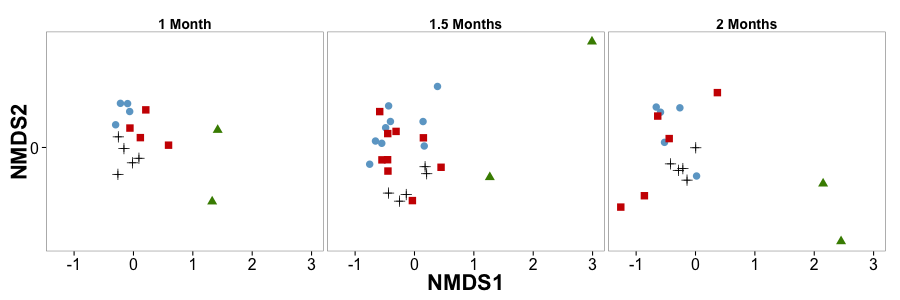

In [10]:
%%R -h 300 -w 900

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"2 Months","2.5 Months"))

p = plot_ordination(ps_snorm, ord.full, color = "Trtmt", shape = "Trtmt")

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend("Mineral"), shape = guide_legend("Mineral"))
# Determines the color theme of the plot overall

p = p + scale_x_continuous(breaks=c(-1,0,1,2,3))
p = p + scale_y_continuous(breaks=c(-2,0,2))

p = p + theme_bw() +
    theme(
    legend.position = "none"
    ,plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold")
    ,axis.title = element_text(size=22, face='bold')
    ,axis.text = element_text(size=16)
    ,legend.text = element_text(size=16)
    ,legend.title = element_text(size = 22)
    ,strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [11]:
%%R
ggsave(filename="NMDS-ITS-3month.jpg", plot=p ,width=8.5, height=3.5)

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.

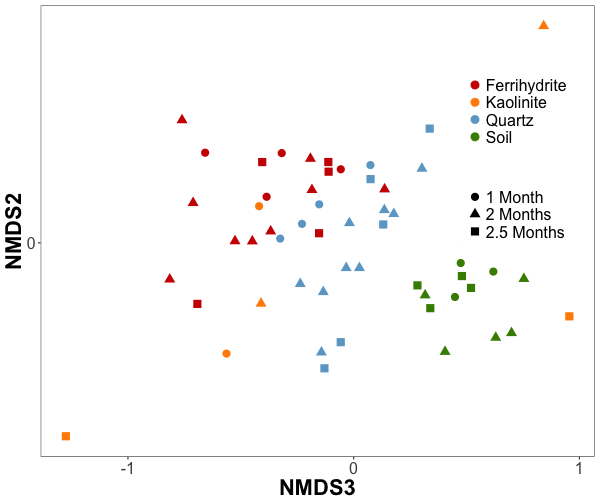

In [12]:
%%R -h 500 -w 600

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"2 Months","2.5 Months"))

p = plot_ordination(ps_snorm, ord.full, color = "Trtmt", shape = "MonthName", axes = c(3,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("red3","darkorange","skyblue3","chartreuse4","black"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))
# Determines the color theme of the plot overall

p = p + scale_x_continuous(breaks=c(-1,0,1,2,3))
p = p + scale_y_continuous(breaks=c(-2,0,2))

p = p + theme_bw() +
    theme(
    #legend.position = "right"
      legend.justification=c(1,1),
      legend.position=c(0.96,0.9)
    ,plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold")
    ,axis.title = element_text(size=22, face='bold')
    ,axis.text = element_text(size=16)
    ,legend.text = element_text(size=16)
    ,legend.title = element_text(size = 22)
    ,strip.background = element_rect(colour="white", fill="white"))

#p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [17]:
%%R
ggsave(filename="NMDS-ITS-AllMonths.Rachel.jpg", plot=p ,width=6, height=6)

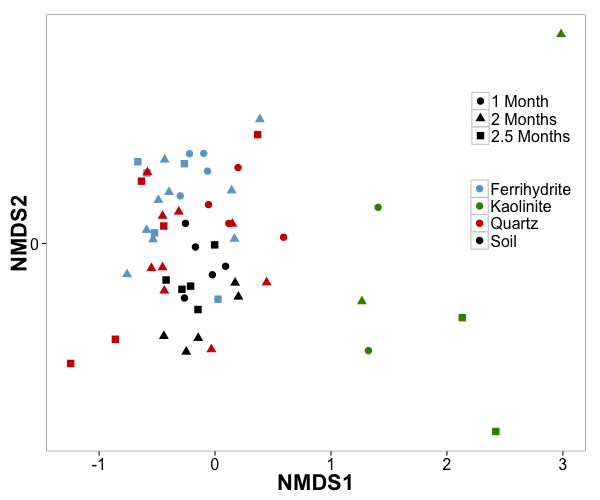

In [9]:
%%R -h 500 -w 600

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"2 Months","2.5 Months"))

p = plot_ordination(ps_snorm, ord.full, color = "Trtmt", shape = "MonthName")

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))
# Determines the color theme of the plot overall

p = p + scale_x_continuous(breaks=c(-1,0,1,2,3))
p = p + scale_y_continuous(breaks=c(-2,0,2))

p = p + theme_bw() +
    theme(
    #legend.position = "right"
      legend.justification=c(1,1),
      legend.position=c(1,0.9)
    ,plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold")
    ,axis.title = element_text(size=22, face='bold')
    ,axis.text = element_text(size=16)
    ,legend.text = element_text(size=16)
    ,legend.title = element_text(size = 22)
    ,strip.background = element_rect(colour="white", fill="white"))

#p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [10]:
%%R
ggsave(filename="NMDS-ITS-AllMonths.AGU.jpg", plot=p ,width=6, height=7)

### Making 3-D plots

In [10]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

#ps_snorm3D = prune_samples(sample_data(ps_snorm)$Month != 2, ps_snorm)
ps_snorm3D = ps_snorm

ord.3D = ordinate(ps_snorm3D, method = "NMDS", distance = "bray", weighted=TRUE, k=3, trymax=40)
# Consider trymax= and k=3

Run 0 stress 0.1359395 
Run 1 stress 0.1376325 
Run 2 stress 0.1362923 
... Procrustes: rmse 0.08210962  max resid 0.2278752 
Run 3 stress 0.1381176 
Run 4 stress 0.134161 
... New best solution
... Procrustes: rmse 0.08450858  max resid 0.4825916 
Run 5 stress 0.1341635 
... Procrustes: rmse 0.003088131  max resid 0.02043849 
Run 6 stress 0.13637 
Run 7 stress 0.1373877 
Run 8 stress 0.1363148 
Run 9 stress 0.138141 
Run 10 stress 0.1371815 
Run 11 stress 0.1375122 
Run 12 stress 0.1341423 
... New best solution
... Procrustes: rmse 0.004053641  max resid 0.01954546 
Run 13 stress 0.1342823 
... Procrustes: rmse 0.007821453  max resid 0.03604433 
Run 14 stress 0.1373607 
Run 15 stress 0.1362559 
Run 16 stress 0.1373666 
Run 17 stress 0.1341384 
... New best solution
... Procrustes: rmse 0.001332569  max resid 0.005481939 
... Similar to previous best
Run 18 stress 0.1393931 
Run 19 stress 0.1343739 
... Procrustes: rmse 0.01032797  max resid 0.04545071 
Run 20 stress 0.1341539 
... Pr

In [11]:
%%R
NMDS.coords = data.frame(ord.3D$points)
# Extracting the coordinates from the ordination
NMDS.coords = merge(NMDS.coords,sample_data(ps_snorm3D), by = 0)
# Merging it with the sample data, by rowname (the same)
dim(NMDS.coords)
# Should be able to make 3D plot with this.

[1] 57  7


In [12]:
%%R
#f <- list(family = "Courier New, monospace",size = 18,color = "#7f7f7f")

plot_ly(NMDS.coords, x = NMDS.coords$MDS1, y = NMDS.coords$MDS2, z = NMDS.coords$MDS3, color = NMDS.coords$Trtmt,
        colors = c("red3","darkorange","skyblue3","chartreuse4")
        #, symbol = NMDS.coords$Month
       )%>%
    layout(scene = list(xaxis = list(title = "NMDS1"), yaxis = list(title = "NMDS2"),
          zaxis = list(title = "NMDS3")))

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No trace type specified:
  Based on info supplied, a 'scatter3d' trace seems appropriate.
  Read more about this trace type -> https://plot.ly/r/reference/#scatter3d

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No scatter3d mode specifed:
  Setting the mode to markers
  Read more about this attribute -> https://plot.ly/r/reference/#scatter-mode

  warnings.warn(x, RRuntimeWarning)


In [13]:
%%R
Sys.setenv("plotly_username"="TheaWhitman")
Sys.setenv("plotly_api_key"="XXX")
plotly_POST(x = last_plot(), filename = "ITSNMDS.3D", fileopt = "overwrite", sharing = "public")

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No encoding supplied: defaulting to UTF-8.

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Success! Modified your plotly here -> https://plot.ly/~TheaWhitman/3

  warnings.warn(x, RRuntimeWarning)
